# Illuminant Invariance Solution for The Challenge Video

The aim of this solution is to make the lane detecting algorithm robost where the color information of the lane line is lost in severe shadow cases.

Illuminant invariance color spaces (e.g. HSV space, LUV space) are generally used as features for detecting colored lane lines. However, under severe shadow conditions, even in these color spaces the color information of a line is lost. As it is the case with the yellow lane line when the vehicle passes under a bridge in the [challenge video](challenge_video.mp4) of [Udacity's advanced lane lines project](https://github.com/udacity/CarND-Advanced-Lane-Lines). In addition to that, the white lane lines are also hardly detectable in severe shadow cases. However, the solution to the colored lines will also make the white lines detectable.

In the following sections, this problem will be demonstrated in detail and a practical solution will be given.

## Dependencies

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## The Helper funcitons

Here, the helper functions will not be explicitly implemented again in the notebook. Instead, functions will be imported from the file [lane_detector](./lane_detector.py). For details of the techniques and the functions please see the [previous report](./project-report.ipynb).

In [2]:
from lane_detector import *

## The Color Thresholding and Illuminant Invariance

To make a lane finding pipeline more robust to shadow and reflection conditions, using a combined color thresholding technique over various color spaces is very effective for detecting colored lane lines (yellow in this case). As an example, below a screen capture is represented from [harder challenge video](./harder_challenge_video.mp4) of [Udacity's advanced lane lines project](https://github.com/udacity/CarND-Advanced-Lane-Lines) which contains shadows from the trees on the road.

(738, 1280, 3)


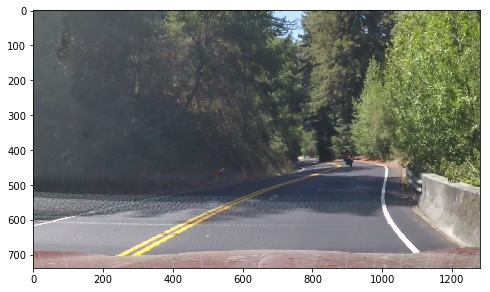

In [3]:
img = cv2.imread('./examples/snap02.png')
print(img.shape)
pltimshow(bgr2rgb(img), (8,16))

An exploration over different color spaces on the image above shows us, for some of the color channels, yellow lane lines are invariant under shadow and lighting conditions.

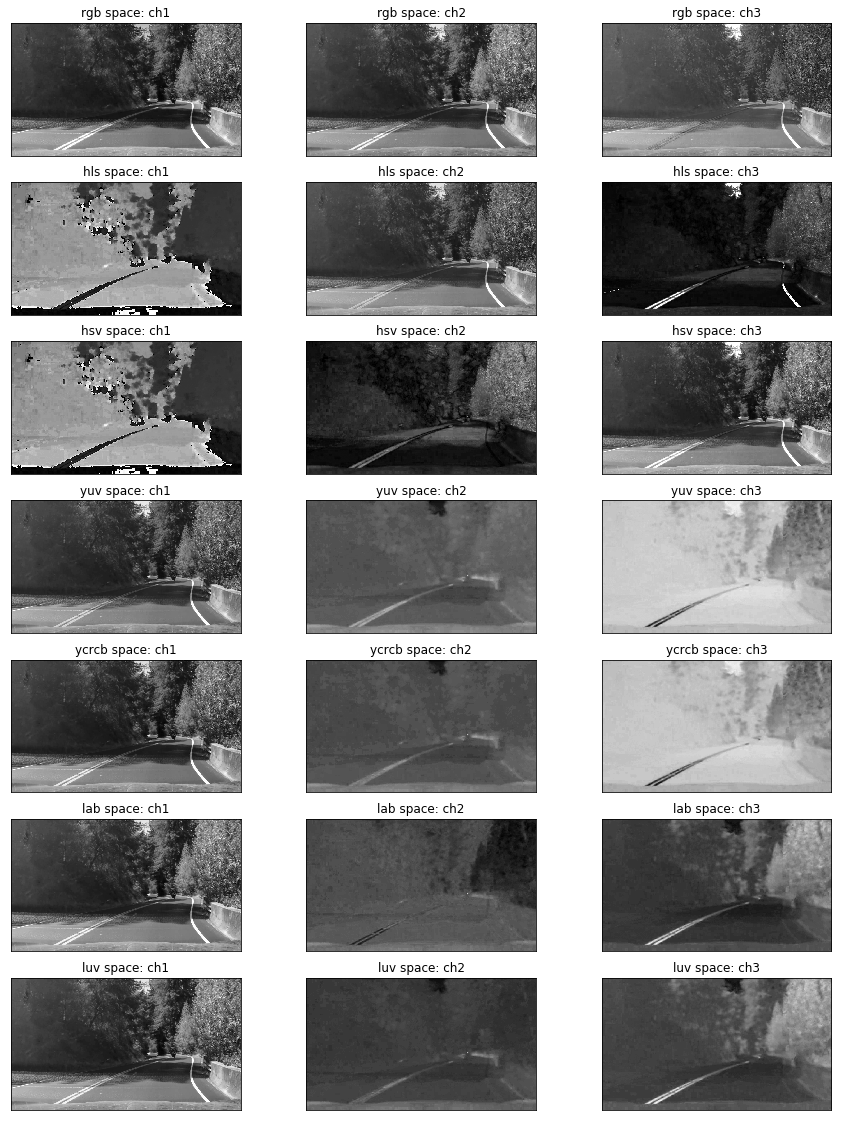

In [4]:
explore_img_color_thr(bgr2rgb(img), binary=False, save_path=None)

As we can see from the examples above, for the yellow lines on the left side of the lane, the information of the lines is very well preserved in some of the color channels like H (Hue) from HSV space (hsv space: ch1) or V from LUV space (luv space: ch3). Whereas it seems also possible to get the information from other color channels like R from RGB space, not all the channels are good at preserving the information under different shadow or reflection cases.

For instance, the reason the colored lines are well preserved and independent from lighting conditions for H channel is, the Hue value represents only the color information of an object and this way, not effected by the changes of the light. Besides, like R channel in RGB color space, some of the channels are also good at detecting white lines using color thresholding techniques. Thus, to get a robost lane detecting pipeline, using a combined color thresholding algorithm with various color channels is mostly suitable. However, when it is a severe shadow case, it is even hard to detect the lines with a combined thresholding just using the color spaces mentioned above.

## The problem

For a colored lane line, the reason it gets hard to detect is the color information is lost in severe shadow cases. This information loss is due to the reflecting light from other surrounding objects ([Z. Ying, G. Li, Sixin Wen and G. Tan, 2017](https://arxiv.org/abs/1708.00975)). For instance, a yellow line in a direct sunlight has a combination of red and green color values in an image. However, when the line is in a severe shadow, the distribution of different colors from the environmental reflections, changes the color information of the pixels on the line.

These two cases are demonstrated in the following two sections as no shadow case and severe shadow case.

### A) No Shadow Case

An image captured from the challenge video when the yellow lane line is in direct sunlight.

(720, 1280, 3)


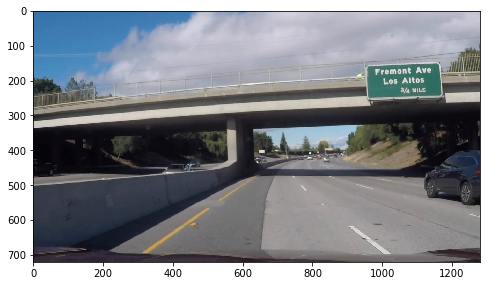

In [5]:
yellow_line = cv2.imread('./examples/severe_shadow/snap01.png')
print(yellow_line.shape)
pltimshow(bgr2rgb(yellow_line), (8,16))

To get the distribution of the color values, yellow pixels are captured from the image and a color histogram is plotted.

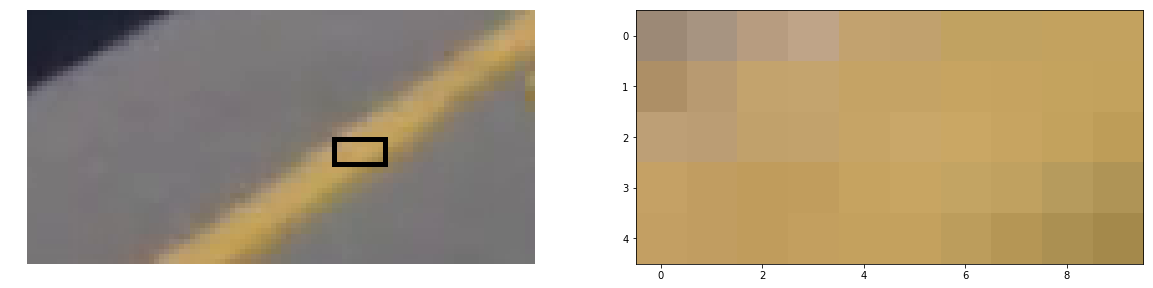

In [6]:
# select the lane region
selected_yellow = np.copy(yellow_line)
cv2.rectangle(selected_yellow, (410,625), (420,630), (0,0,0), 1)

selected_yellow_pixels = yellow_line[625:630,410:420]

# plot the yellow pixels
plt.figure(figsize=(20,30))
plt.subplot(1,2,1)
plt.imshow(bgr2rgb(selected_yellow)[600:650,350:450])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(bgr2rgb(selected_yellow_pixels))
plt.show()
plt.close()

Captured yellow line pixels.

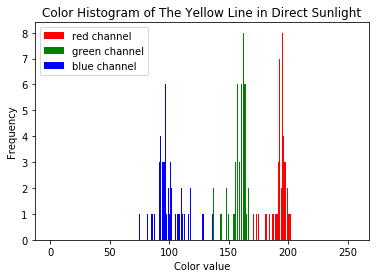

In [7]:
# plot red green and blue color distributions in a histogram
yellow_line_hist_b = cv2.calcHist([selected_yellow_pixels[:,:,0]],[0],None,[256],[0,256])
yellow_line_hist_g = cv2.calcHist([selected_yellow_pixels[:,:,1]],[0],None,[256],[0,256])
yellow_line_hist_r = cv2.calcHist([selected_yellow_pixels[:,:,2]],[0],None,[256],[0,256])

intensity_x = np.arange(256)
plt.bar(intensity_x, yellow_line_hist_r[:,0], color='red', label='red channel')
plt.bar(intensity_x, yellow_line_hist_g[:,0], color='green', label='green channel')
plt.bar(intensity_x, yellow_line_hist_b[:,0], color='blue', label='blue channel')
plt.title('Color Histogram of The Yellow Line in Direct Sunlight')
plt.ylabel('Frequency')
plt.xlabel('Color value')
plt.legend(loc='upper left')
plt.show()

The histogram gives the frequency of the color values for each red, green and blue channel where each color channel plotted with the same color as it is. As can be seen from the histogram, yellow line pixels mostly have a mixture of red and green color values where the blue color values are lower.

### B) Severe Shadow Case

To demonstrate the severe shadow case, an image is also captured from the challenge video when the vehicle passes under the bridge.

(720, 1280, 3)


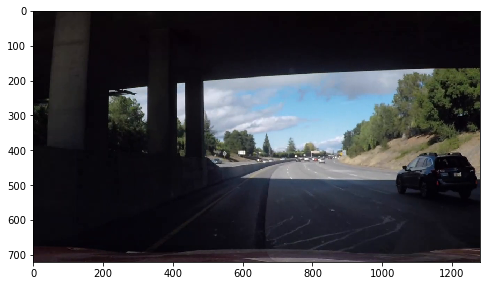

In [8]:
# display severe shadow case image
shadowed_line = cv2.imread('./examples/severe_shadow/snap03.png')
print(shadowed_line.shape)
pltimshow(bgr2rgb(shadowed_line), (8,16))

The same spot, this time, is in a severe shadow where the lighting is weak. To see the distributions, the yellow line pixels from this same spot is again captured and the histogram is plotted.

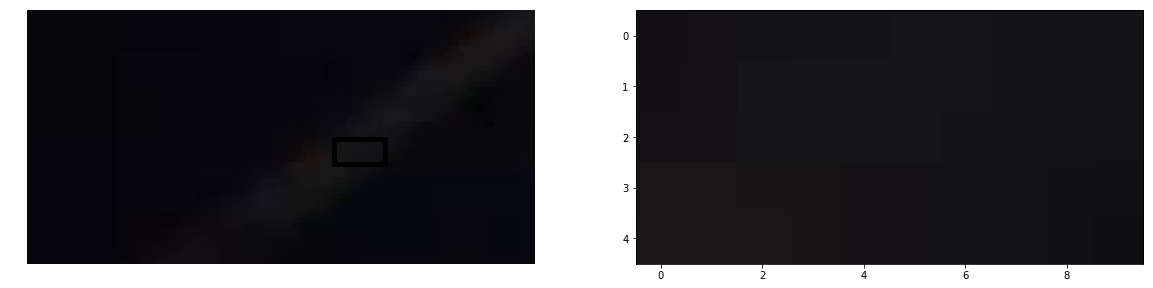

In [9]:
# select the lane region
selected_shadowed = np.copy(shadowed_line)
cv2.rectangle(selected_shadowed, (410,625), (420,630), (0,0,0), 1)

selected_shadowed_pixels = shadowed_line[625:630,410:420]

plt.figure(figsize=(20,30))
plt.subplot(1,2,1)
plt.imshow(bgr2rgb(selected_shadowed)[600:650,350:450])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(bgr2rgb(selected_shadowed_pixels))
plt.show()
plt.close()

Captured yellow lane lines in severe shadow case.

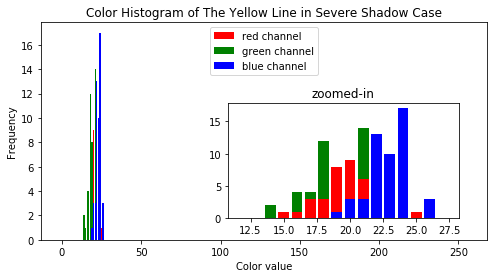

In [10]:
shadowed_hist_b = cv2.calcHist([selected_shadowed_pixels[:,:,0]],[0],None,[256],[0,256])
shadowed_hist_g = cv2.calcHist([selected_shadowed_pixels[:,:,1]],[0],None,[256],[0,256])
shadowed_hist_r = cv2.calcHist([selected_shadowed_pixels[:,:,2]],[0],None,[256],[0,256])

plt.figure(figsize=(8,4))
plt.bar(intensity_x, shadowed_hist_r, color='red', label='red channel')
plt.bar(intensity_x, shadowed_hist_g, color='green', label='green channel')
plt.bar(intensity_x, shadowed_hist_b, color='blue', label='blue channel')
plt.title('Color Histogram of The Yellow Line in Severe Shadow Case')
plt.ylabel('Frequency')
plt.xlabel('Color value')
plt.legend(loc='upper center')
left, bottom, width, height = [0.45, 0.2, 0.4, 0.4]
plt.axes([left, bottom, width, height])
plt.bar(intensity_x[12:28], shadowed_hist_g[12:28], color='green')
plt.bar(intensity_x[12:28], shadowed_hist_r[12:28], color='red')
plt.bar(intensity_x[12:28], shadowed_hist_b[12:28], color='blue')
plt.title('zoomed-in')
plt.show()
plt.close()

As can be seen from the frequency distributions, the color values of red and green pixels drop rapidly and the blue color distribution gets as a noise in the mixed distributions of red and green.

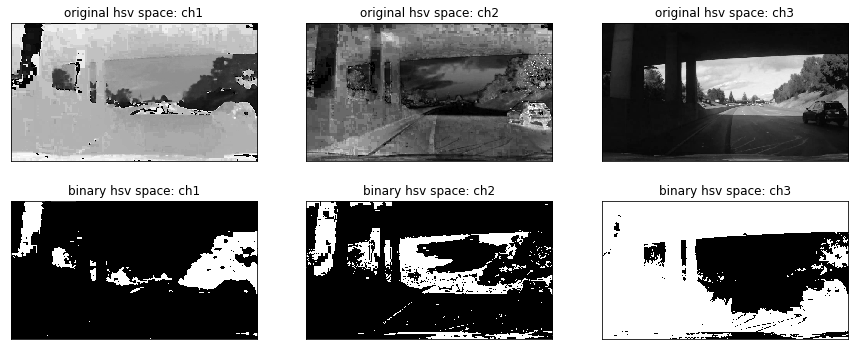

In [11]:
bin_hsv_ch1, bin_hsv_ch2, bin_hsv_ch3 =\
    color_thresholding(bgr2rgb(shadowed_line), ch_type='hsv', thr=(0, 50), plot=True)

For the severe shadow case image, each channel representations (hue, saturation and value) of the HSV space is given above. The first row is the direct representations of the channels, and the second row is the binary representations for the same channels after a thresholding is applied. As it can be seen from the hue channel, it is not possible to get any line information. Here in this case, the saturation channel (hsv space: ch2) seems to have the line information. However, representations of the saturation is very unstable under changing lighting conditions, thus implementing a generalized thresholding algorithm with the saturation channel is not a reliable solution.

## The Solution

The yellow color is a combination of red and green colors in RGB color space, and in severe shadow cases, the color information is lost due to the noisy color distributions of the environmental reflections. However, in this case the distribution of the reflected environmental colors are very different from the distributions of the object's (the yellow lane line) red and green colors. Thus it becomes possible to separate this noise by applying a [histogram equalization](https://en.wikipedia.org/wiki/Histogram_equalization) on each RGB channels separately. By applying the histogram equalizations, the same mathematical operation will be applied for each channel. This way, the operation on the very similarly distributed object's true colors will result similarly. However, the same operation will result very different for reflected environmental colors. This way, it becomes possible to separate the environmental color distributions from the true color distributions which will result in getting the yellow color information back.

### Histogram Equalization Applied Case

To implement this solution, first, the color channels (in RGB color space) of the image are seperated and histogram equalization is applied seperately on each of these channels. After the operation, the resulting channels are stacked back together as forming an image with red, green and blue channels again.

(720, 1280, 3)


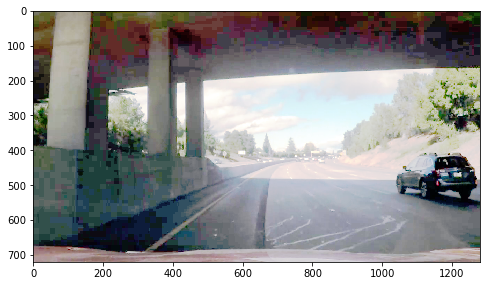

In [12]:
# separate RGB channels
ch1 = shadowed_line[:,:,0] # blue channel
ch2 = shadowed_line[:,:,1] # green channel
ch3 = shadowed_line[:,:,2] # red channel

# apply histogram equalization for each channel
equ1 = cv2.equalizeHist(ch1)
equ2 = cv2.equalizeHist(ch2)
equ3 = cv2.equalizeHist(ch3)

# stack/combine channels again
histeq = np.dstack((equ1,equ2,equ3))

print(histeq.shape)
pltimshow(bgr2rgb(histeq), (8,16))

The resulting image is shown above after histogram equalizations are applied. To investigate the resulting color distributions, histogram of the same yellow pixels are plotted again.

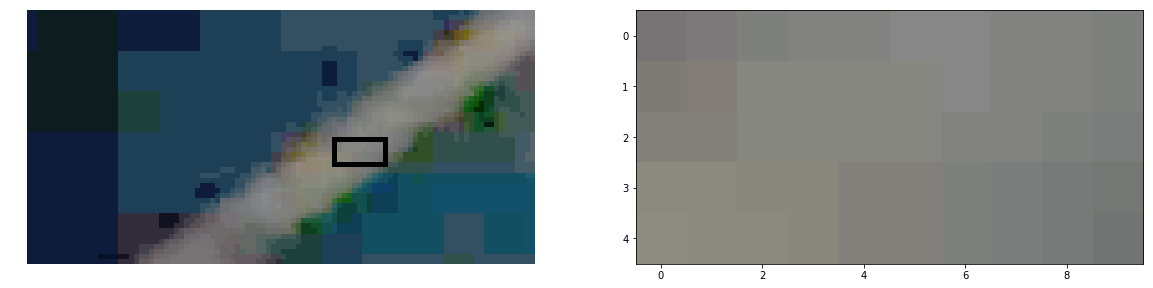

In [13]:
# select the lane region for the image with histogram equalization
selected_histeq = np.copy(histeq)
cv2.rectangle(selected_histeq, (410,625), (420,630), (0,0,0), 1)

selected_histeq_pixels = histeq[625:630,410:420]

plt.figure(figsize=(20,30))
plt.subplot(1,2,1)
plt.imshow(bgr2rgb(selected_histeq)[600:650,350:450])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(bgr2rgb(selected_histeq_pixels))
plt.show()
plt.close()

Captured yellow line pixels after the histogram equalizations are applied.

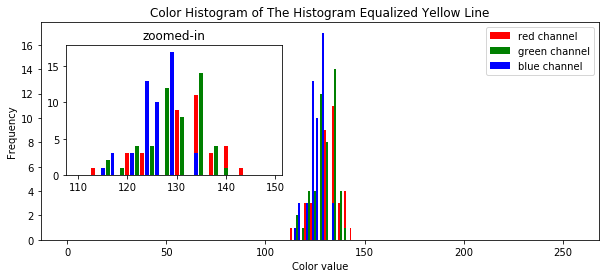

In [14]:
# plot the histogram
histeq_hist_b = cv2.calcHist([selected_histeq_pixels[:,:,0]],[0],None,[256],[0,256])
histeq_hist_g = cv2.calcHist([selected_histeq_pixels[:,:,1]],[0],None,[256],[0,256])
histeq_hist_r = cv2.calcHist([selected_histeq_pixels[:,:,2]],[0],None,[256],[0,256])

plt.figure(figsize=(10,4))
plt.bar(intensity_x, histeq_hist_r, color='red', label='red channel')
plt.bar(intensity_x, histeq_hist_g, color='green', label='green channel')
plt.bar(intensity_x, histeq_hist_b, color='blue', label='blue channel')
plt.title('Color Histogram of The Histogram Equalized Yellow Line')
plt.ylabel('Frequency')
plt.xlabel('Color value')
plt.legend(loc='upper right')
left, bottom, width, height = [0.16, 0.35, 0.3, 0.45]
plt.axes([left, bottom, width, height])
plt.bar(intensity_x[110:150], histeq_hist_r[110:150], color='red', label='red channel')
plt.bar(intensity_x[110:150], histeq_hist_g[110:150], color='green', label='green channel')
plt.bar(intensity_x[110:150], histeq_hist_b[110:150], color='blue', label='blue channel')
plt.title('zoomed-in')
plt.show()

As it can be seen from the frequencies above, the color distributions get higher values than the previous original image, and the distibution of the blue color values are being separated from red and green color distributions. This way, the information of the yellow color should remain on the resulting image and should be detectable on the hue channel of the HSV color space.

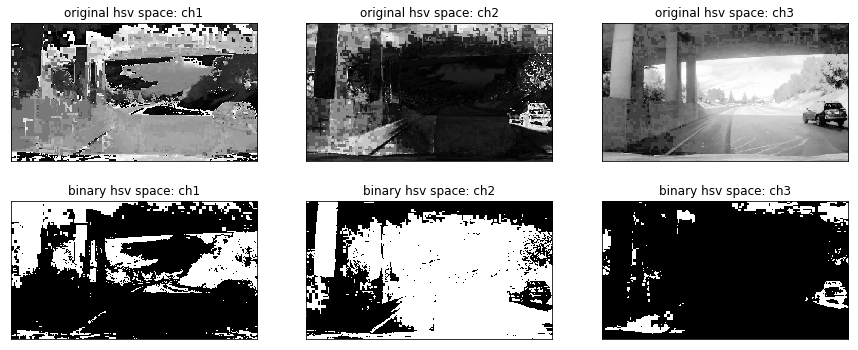

In [15]:
bin_hsv_ch1, bin_hsv_ch2, bin_hsv_ch3 =\
    color_thresholding(bgr2rgb(histeq), ch_type='hsv', thr=(0, 50), plot=True)

HSV color space representations are plotted again for the resulting image and this time the yellow line remains on H channel. In addition, after the histogram equalization, applying a Gaussian blur on the blue channel with high kernel sizes and high kernel standard deviations improves the results.

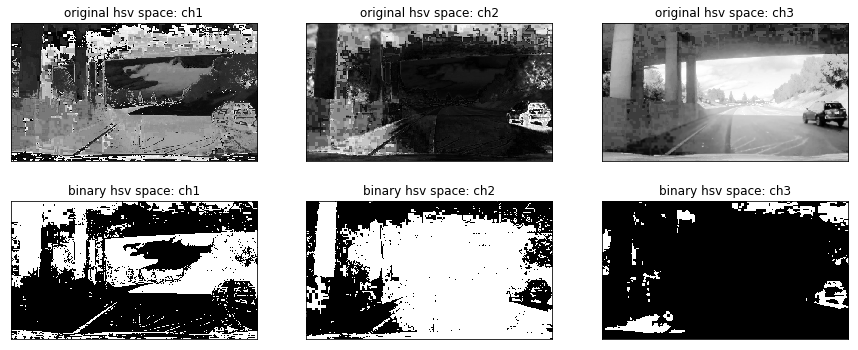

In [16]:
# blur the blue channel
# separate RGB channels
ch1 = shadowed_line[:,:,0] # blue channel
ch2 = shadowed_line[:,:,1] # green channel
ch3 = shadowed_line[:,:,2] # red channel

# apply histogram equalization
equ1 = cv2.equalizeHist(ch1)
equ2 = cv2.equalizeHist(ch2)
equ3 = cv2.equalizeHist(ch3)
# apply gaussian blur to blue channel
equ1 = cv2.GaussianBlur(equ1,(9,9),39)

# stack, combine channels again
blured_histeq = np.dstack((equ1,equ2,equ3))

bin_hsv_ch1, bin_hsv_ch2, bin_hsv_ch3 =\
    color_thresholding(bgr2rgb(blured_histeq), ch_type='hsv', thr=(0, 50), plot=True)

The yellow line is very well preserved on H channel of HSV space.

## Results

To compare the results between the original image with the severe shadow condition and the solution applied image, the lane as being the region of interest, the viewpoint will be transformed to bird's-eye view.

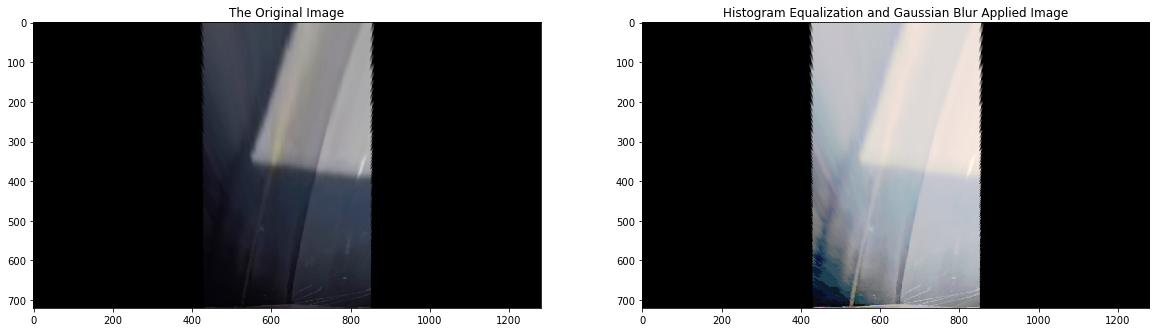

In [17]:
# transform viewpoint to bird's eye for original image
out_imgs, measurements = lane_detector(
    shadowed_line, c_mtx=c_mtx, dist=dist, std_max=15., min_samp=30)
birds_eye_RGB = bgr2rgb(out_imgs[0])
# transform viewpoint to bird's eye for the resulting image
out_imgs, measurements = lane_detector(
    blured_histeq, c_mtx=c_mtx, dist=dist, std_max=15., min_samp=30)
birds_eye_RGB_histeq = bgr2rgb(out_imgs[0])

plt.figure(figsize=(20,30))
plt.subplot(121)
plt.imshow(birds_eye_RGB)
plt.title('The Original Image')
plt.subplot(122)
plt.title('Histogram Equalization and Gaussian Blur Applied Image')
plt.imshow(birds_eye_RGB_histeq)
plt.show()
plt.close()

Two of the images above are the road regions from the severe shadow case image with the viewpoints transformed to bird's-eye view. The image on the left is the original and the image on the right is the one with the histogram equalization and Gaussian blur solution is applied. A color thresholding will be applied to these images to compare the results.

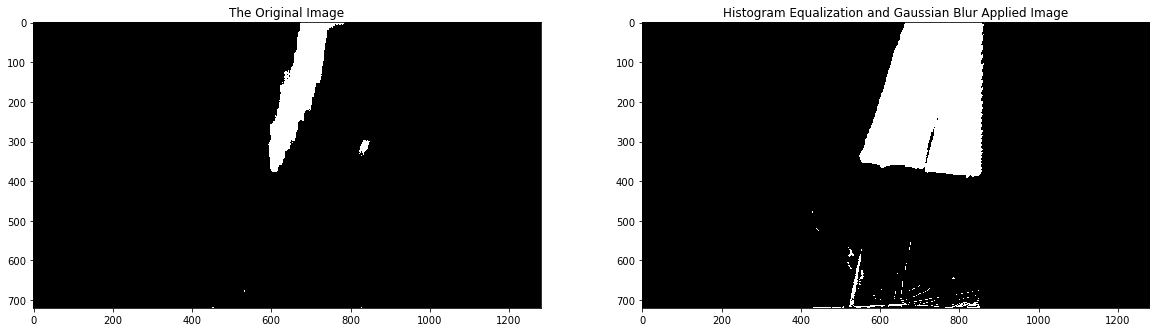

In [18]:
# apply color thresholding to the original image
bin_hsv_ch1, _, _ = color_thresholding(
    birds_eye_RGB, ch_type='hsv', thr=(0, 50), plot=False)

# apply color thresholding to the solution image
bin_hsv_ch1_hist_eq, _, _ = color_thresholding(
    birds_eye_RGB_histeq, ch_type='hsv', thr=(0, 50), plot=False)

# plot both
plt.figure(figsize=(20,30))
plt.subplot(121)
plt.imshow(bin_hsv_ch1, cmap='gray')
plt.title('The Original Image')
plt.subplot(122)
plt.title('Histogram Equalization and Gaussian Blur Applied Image')
plt.imshow(bin_hsv_ch1_hist_eq, cmap='gray')
plt.show()
plt.close()

After the color thresholding, the original image on the left has no line pixels detected, but the solution image on the right detects the line pixels successfully. In addition, since applying histogram equalization on each channel gets the yellow line pixels to higher color values for red, green and blue channels, it is also possible to apply an extra thresholding to the solution image in the RGB space to detect the remaining distant line pixels of the yellow line.

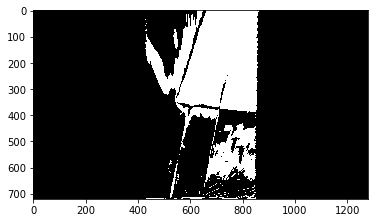

In [19]:
# Apply a color thresholding for the solution image on the RGB space to get 
# the distant line pixels
# thresholding range is (170, 190) for the R channel
binary = combined_color_thresholding(
    birds_eye_RGB_histeq, thr_rgb=(170, 190), thr_hsv=(0,0), thr_luv=(0,0))

# Combine the results
bi = np.zeros_like(bin_hsv_ch1)
bi[(bin_hsv_ch1_hist_eq == 1) | (binary == 1)] = 1

plt.imshow(bi, cmap='gray')
plt.show()
plt.close()

The final binary image with the combined thresholing is plotted above. As the result, the yellow lane line is detectable even under the severe shadow cases. It is now possible with a sliding window line detection system to seperate the noise and detect the lines accurately.

### White lane lines

By applying histogram equalizations to each channel in RGB space, values of red, green and blue channels for the white pixels are also rises up. This way, applying a color thresholding in RGB space for high valued red, green and blue values together, it becomes possible to detect the white line pixels.

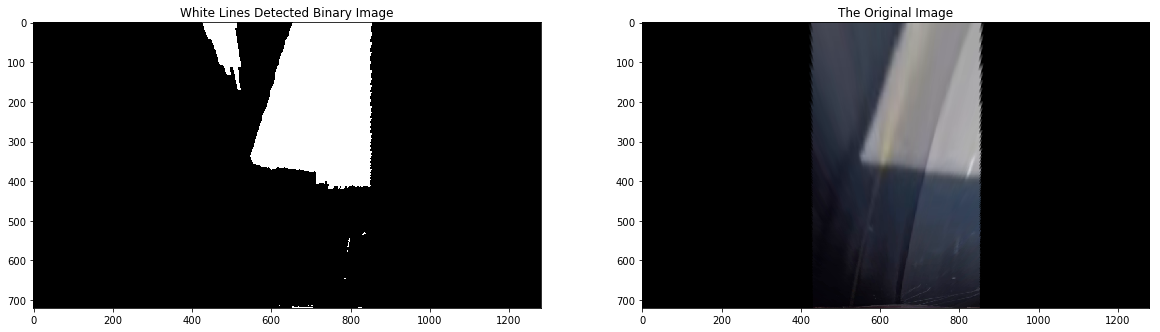

In [20]:
# apply binary thresholding to detect white pixels
binary = combined_color_thresholding(
    birds_eye_RGB_histeq, thr_rgb=(195, 255), thr_hsv=(0,0), thr_luv=(0,0))

plt.figure(figsize=(20,30))
plt.subplot(121)
plt.title('White Lines Detected Binary Image')
plt.imshow(binary, cmap='gray')
plt.subplot(122)
plt.imshow(birds_eye_RGB)
plt.title('The Original Image')
plt.show()
plt.close()

The white line pixels on the right of the lane are also detectable in the weak lighting condition. A combined search algorithm with sliding windows can be implemented to detect on the resulting binary images.

## Conclusions

The color invariant channels, such as Hue in HSV space, are suitable for detecting the colored lane pixels. However, when the lighting is weak under severe shadow cases, the color information of the objects are easily lost due to envorimental reflections. As demonstrated above, the solution with the histogram equalization separates the environmental colors and helps to get the true color information back. Since the color values rises up after the histogram equalization operation, it also gets possible to filter the white line pixels for very high values in the severe shadow cases. After the solution is applied, it is possible to mark lane pixels with sliding window searches from these filtered binary images.

---